In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import sklearn.metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm


# Código

##Leitura e tabela

In [60]:
dados = pd.read_csv("https://github.com/Vilardino/AM-1/blob/main/Obesidade.csv?raw=true")
scaler = MinMaxScaler() 
#dados = dados.drop(columns=['Weight']) #quando nao comentado é retirado o peso do dataset
X = scaler.fit_transform(dados.iloc[0:, :16].to_numpy()) #trocar para 15 ao remover a coluna
Y = dados.iloc[0:,16].values #trocar para 15 ao remover a coluna

In [61]:
#dados.DESCR #ignora q ta dando bo
dados.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,3,Normal_Weight
1,1,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,3,Normal_Weight
2,0,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,3,Normal_Weight
3,0,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,4,Overweight_Level_I
4,0,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,3,Overweight_Level_II


##Separa treino

In [62]:
x_tr, x_te, y_tr, y_te = train_test_split(X, Y,
                                            test_size = 0.2,
                                            random_state=33,
                                            stratify=Y)

print(x_tr.shape)
print(x_te.shape)

(1688, 16)
(423, 16)


##Arvore de decisão

In [63]:
dtc = DecisionTreeClassifier(random_state=33)
dtc.fit(x_tr, y_tr)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=33, splitter='best')

In [64]:
y_pred = dtc.predict(x_te)
accuracy_score(y_te, y_pred)

0.9385342789598109

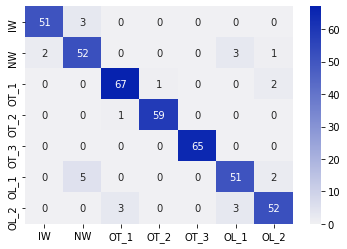

In [65]:
conf_mat = sklearn.metrics.confusion_matrix(y_te, y_pred)


df_cm = pd.DataFrame(conf_mat, columns = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'],
                     index = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'])

cmap = sns.light_palette("#0622af", as_cmap=True)
plt.figure()
sns.heatmap(df_cm, annot=True, cmap=cmap)

In [66]:
tr_acc = []
tr_std = []

for this_md in range(2,50):
    dtc = DecisionTreeClassifier(max_depth=this_md,random_state=33)
    dtc.fit(x_tr, y_tr)
    scores = cross_val_score(dtc, x_tr, y_tr, cv=10)
    tr_acc.append(scores.mean())
    tr_std.append(np.std(scores))

###Erros com base na profundidade

<ErrorbarContainer object of 3 artists>

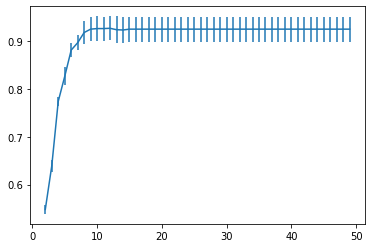

In [67]:
plt.errorbar(x=range(2,50), y=tr_acc, yerr=tr_std)

In [68]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': range(2,30,2),
              'min_samples_leaf': range(2,10,2),
              'min_impurity_decrease': np.linspace(0,0.5,10)}
dtc = DecisionTreeClassifier()
gs = GridSearchCV(dtc, param_grid=param_grid)
gs.fit(x_tr, y_tr)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                

In [69]:
gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=26, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

###Arvore de decisão com melhores hiperparemetros

In [70]:
dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=33, splitter='best')

dtc.fit(x_tr, y_tr)
y_pred_DTC = dtc.predict(x_te)
accuracy_score(y_te, y_pred_DTC)

0.9527186761229315

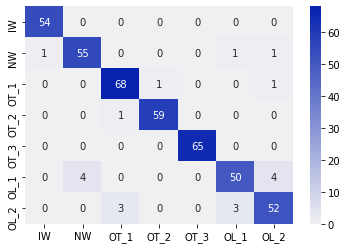

In [71]:
conf_mat = sklearn.metrics.confusion_matrix(y_te, y_pred_DTC)


df_cm = pd.DataFrame(conf_mat, columns = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'],
                     index = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'])

cmap = sns.light_palette("#0622af", as_cmap=True)
plt.figure()
sns.heatmap(df_cm, annot=True, cmap=cmap)

##Vizinhos próximos


In [72]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(1,15,2),
              'metric': ['euclidean', 'manhattan']}

knc = KNeighborsClassifier()
gs = GridSearchCV(knc, param_grid=param_grid)
gs.fit(x_tr, y_tr)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 15, 2),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [73]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [74]:
knc = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

knc.fit(x_tr, y_tr)
y_pred_knc = knc.predict(x_te)
accuracy_score(y_te, y_pred_knc)

0.8368794326241135

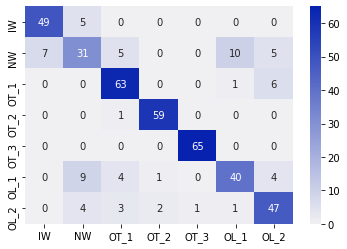

In [75]:
conf_mat = sklearn.metrics.confusion_matrix(y_te, y_pred_knc)

df_cm = pd.DataFrame(conf_mat, columns = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'],
                     index = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'])

cmap = sns.light_palette("#0622af", as_cmap=True)
plt.figure()
sns.heatmap(df_cm, annot=True, cmap=cmap)

###Vizinhos próximos com escalonamento

In [76]:
scaler = StandardScaler().fit(x_tr)
x_tr_scaled = scaler.transform(x_tr)

In [77]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': range(1,15,2),
              'metric': ['euclidean', 'manhattan']}

knc2 = KNeighborsClassifier()
gs = GridSearchCV(knc2, param_grid=param_grid)
gs.fit(x_tr_scaled, y_tr)

gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [78]:
knc2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

knc2.fit(x_tr_scaled, y_tr)
y_pred_knc2 = knc2.predict(scaler.transform(x_te))
accuracy_score(y_te, y_pred_knc2)

0.8439716312056738

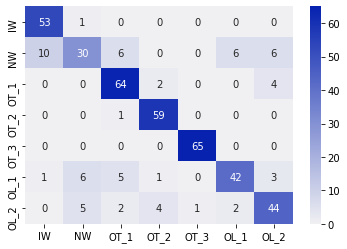

In [79]:
conf_mat = sklearn.metrics.confusion_matrix(y_te, y_pred_knc2)

df_cm = pd.DataFrame(conf_mat, columns = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'],
                     index = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'])

cmap = sns.light_palette("#0622af", as_cmap=True)
plt.figure()
sns.heatmap(df_cm, annot=True, cmap=cmap)

##Máquina de vetores de suporte

In [80]:
clf = svm.SVC(C = 100, gamma = 1, kernel='linear', random_state=33)
clf.fit(x_tr, y_tr)
y_pred = clf.predict(x_te)
print(accuracy_score(y_te, y_pred))

0.9739952718676123


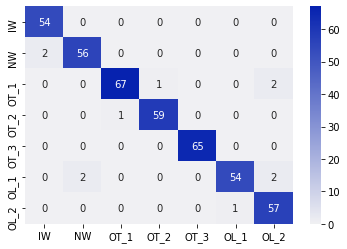

In [81]:
conf_mat = sklearn.metrics.confusion_matrix(y_te, y_pred)

df_cm = pd.DataFrame(conf_mat, columns = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'],
                     index = ['IW', 'NW','OT_1', 'OT_2', 'OT_3', 'OL_1', 'OL_2'])

cmap = sns.light_palette("#0622af", as_cmap=True)
plt.figure()
sns.heatmap(df_cm, annot=True, cmap=cmap)